In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_pairplot_with_truth(
    hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5
):
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(f"[INFO] samples.shape = {samples.shape}")

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()

    # PairGrid: 自定义绘图
    g = sns.PairGrid(df, corner=True, diag_sharey=False)
    g.map_lower(sns.kdeplot, fill=False, levels=[0.393, 0.864], color="C0", linewidths=1)
    g.map_lower(sns.scatterplot, s=5, alpha=0.1, color="gray")
    # g.map_diag(sns.kdeplot, fill=True, color="skyblue", linewidth=1)
    g.map_diag(sns.histplot, kde=True, stat="density", color="C0", linewidth=1)

    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            # if i == j:
            #     if truths:
            #         ax.axvline(truths[i], color="red", linestyle="--", lw=1)

            #         # 添加 65% 和 95% 的置信区间线
            #         vals = df[labels[i]].values
            #         low_65, high_65 = np.percentile(vals, [17.5, 82.5])
            #         low_95, high_95 = np.percentile(vals, [2.5, 97.5])
            #         ax.axvline(low_65, color="orange", linestyle=":", lw=1)
            #         ax.axvline(high_65, color="orange", linestyle=":", lw=1)
            #         ax.axvline(low_95, color="green", linestyle=":", lw=1)
            #         ax.axvline(high_95, color="green", linestyle=":", lw=1)
            # else:
            #     mean_y = means[labels[i]]
            #     std_y = stds[labels[i]]
            #     ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)

            if truths and i!= j:
                ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)

    plt.tight_layout()
    plt.show()


(15800, 5)


<Figure size 1920x1440 with 0 Axes>

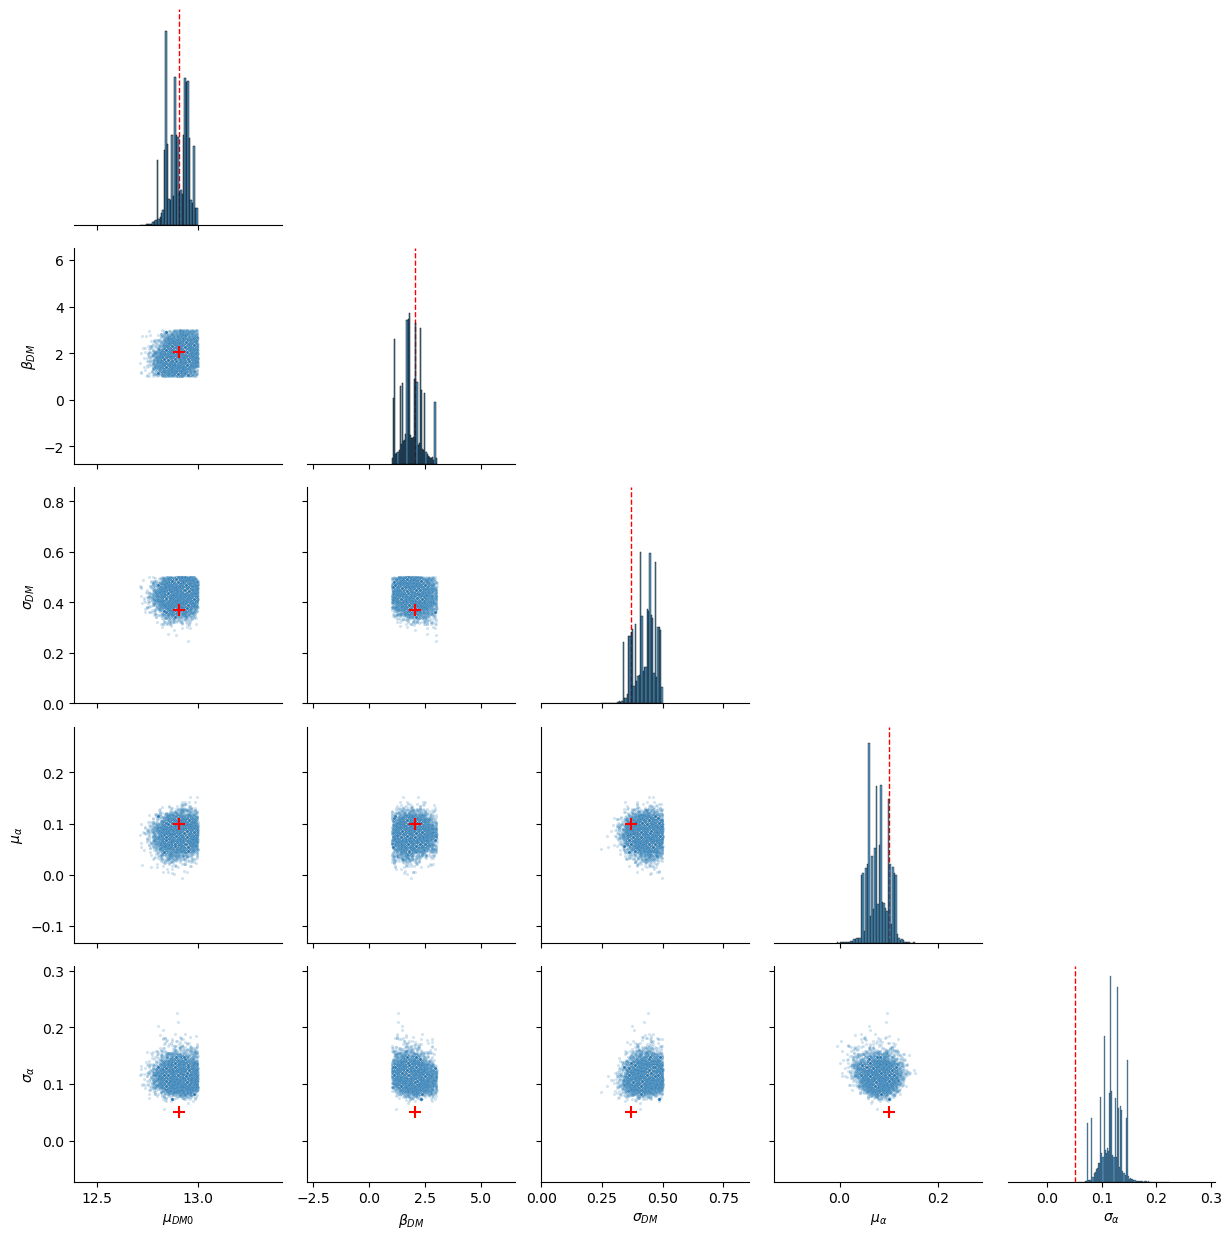

In [8]:
plot_pairplot_with_truth(
    hdf5_file="../chains/chains_eta_new_table.h5",
    discard=100,
    thin=10,
    labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=[12.91, 2.04, 0.37, 0.1, 0.05],
    width_factor=10
)


(3840, 5)


/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_63921/3121466311.py:119: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


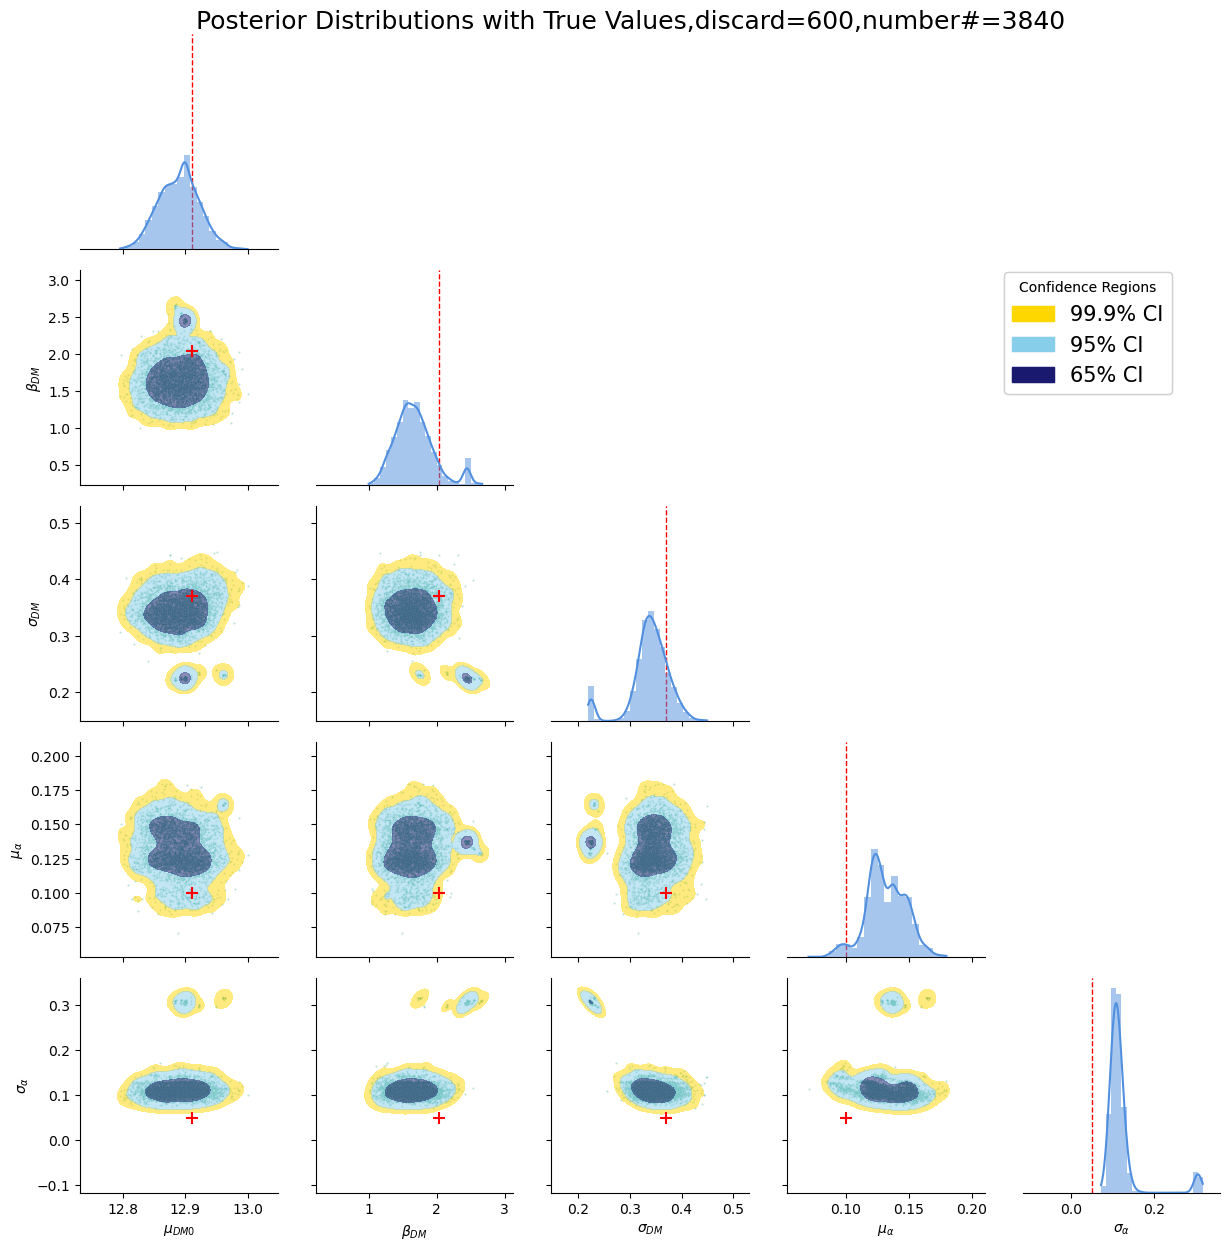

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend
import matplotlib.patches as mpatches

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5):
    """
    使用 Seaborn pairplot 绘制后验图，并以变量均值为中心设置 xlim/ylim，同时标出真值。

    参数：
    - hdf5_file: emcee 的 HDF5 后端路径
    - discard: 前期丢弃步数
    - thin: 抽样间隔
    - labels: 变量标签列表
    - truths: list[float]，真值点，会在每个图上标注
    - width_factor: 控制坐标轴范围宽度因子
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(samples.shape)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()
    # fig = plt.figure(dpi=300)
    # g = sns.pairplot(df, corner=True, diag_kind="hist", plot_kws=dict(s=5, alpha=0.2))
    # g.map_lower(sns.scatterplot, s=5, alpha=0.2)
    # g.map_diag(sns.histplot, kde=True)  # ✅ 这里 hist+KDE 都画
    # 创建 PairGrid
    g = sns.PairGrid(df, corner=True)

    # 下三角：散点图（柔和蓝色点）
    g.map_lower(sns.scatterplot, s=2, alpha=0.4, color="#46B48E")  # steelblue

    # 对角线：直方图 + KDE（海军蓝线 + 浅灰柱）
    g.map_diag(
        sns.histplot,
        kde=True,
        bins=20,
        color="#518FDF",         # lightsteelblue（bar）
        # kde_kws={"color": "#1E3F66", "lw": 1.2},  # navyish KDE
        edgecolor="none",
        alpha=0.5,
    )

    # 下三角 KDE fill：置信区间（深蓝填充）
    g.map_lower(
        lambda x, y, **kwargs: sns.kdeplot(
            x=x,
            y=y,
            fill=True,
            thresh=1,
            levels=[0.01, 0.05, 0.35,1],  # 95%, 65%
            colors=["gold", "skyblue", "midnightblue"], #only need two colors for two levels
            alpha=0.5,
            # shade=True,
            # palette="crest",
            # linewidths=0,
            **kwargs
        )
    )


    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            # 设置 xlim 和 ylim 居中
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    # 添加红色十字真值点
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    # plt.savefig("post.png",dpi=300)
    # plt.title("Pairplot with Truth Values", fontsize=16)
    plt.suptitle(f"Posterior Distributions with True Values,discard={discard},number#={samples.shape[0]}", fontsize=18, y=1)


    
    # 添加自定义图例说明置信区间
    legend_patches = [
    mpatches.Patch(color="gold", label="99.9% CI"),
    mpatches.Patch(color="skyblue", label="95% CI"),
    mpatches.Patch(color="midnightblue", label="65% CI"),
    ]
    # # fig = plt.gcf()
    # fig.legend(
    #     handles=legend_patches,
    #     loc="center right",       # 相对于整个图像
    #     bbox_to_anchor=(0.5, 1.02),
    #     ncol=1,
    #     fontsize=20
    # )

    # plt.legend(handles=legend_patches, title="Confidence Regions", loc="upper left", borderaxespad=0.)
    legend = plt.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(2, 4), title="Confidence Regions", fontsize=15)
    plt.gcf().add_artist(legend)




    plt.tight_layout()
    plt.show()



plot_pairplot_with_truth(
    hdf5_file="../chains/chains_eta_new_table_no_eta_variedms10006_sigma001.h5",
    discard=600,
    thin=10,
    labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],  # Example parameter names
    # truths=[12.575, 0.381, 0.073, 0.075],
    truths=[12.91, 2.04, 0.37, 0.1, 0.05],
    width_factor=5
)
#  np.array([12.5, 0.38, 0.05, 0.05])

# true
# (12.484790712318109,
#  0.4365785108229181,
#  0.07376295948617051,
#  0.0748739106362481)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_chains(hdf5_file, discard=0, thin=1, labels=None, max_steps=None):
    """
    画出 emcee 的采样链条（trace plot），每个 walker 一条线。

    参数：
    - hdf5_file: HDFBackend 文件路径
    - discard: 丢弃 burn-in 步数
    - thin: 稀疏采样间隔
    - labels: 每个参数的名字（list[str]）
    - max_steps: 最多显示多少步（用于调试）
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    chain = backend.get_chain(discard=discard, thin=thin)  # shape: (nsteps, nwalkers, ndim)

    nsteps, nwalkers, ndim = chain.shape

    if max_steps:
        chain = chain[:max_steps]

    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]

    fig, axes = plt.subplots(ndim, 1, figsize=(10, 2.2 * ndim), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        for walker in range(nwalkers):
            ax.plot(chain[:, walker, i], alpha=0.4, lw=0.5)
        ax.set_ylabel(labels[i])
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Step number")
    plt.suptitle("MCMC Chains (Trace Plot)", fontsize=16)
    plt.tight_layout()
    plt.show()


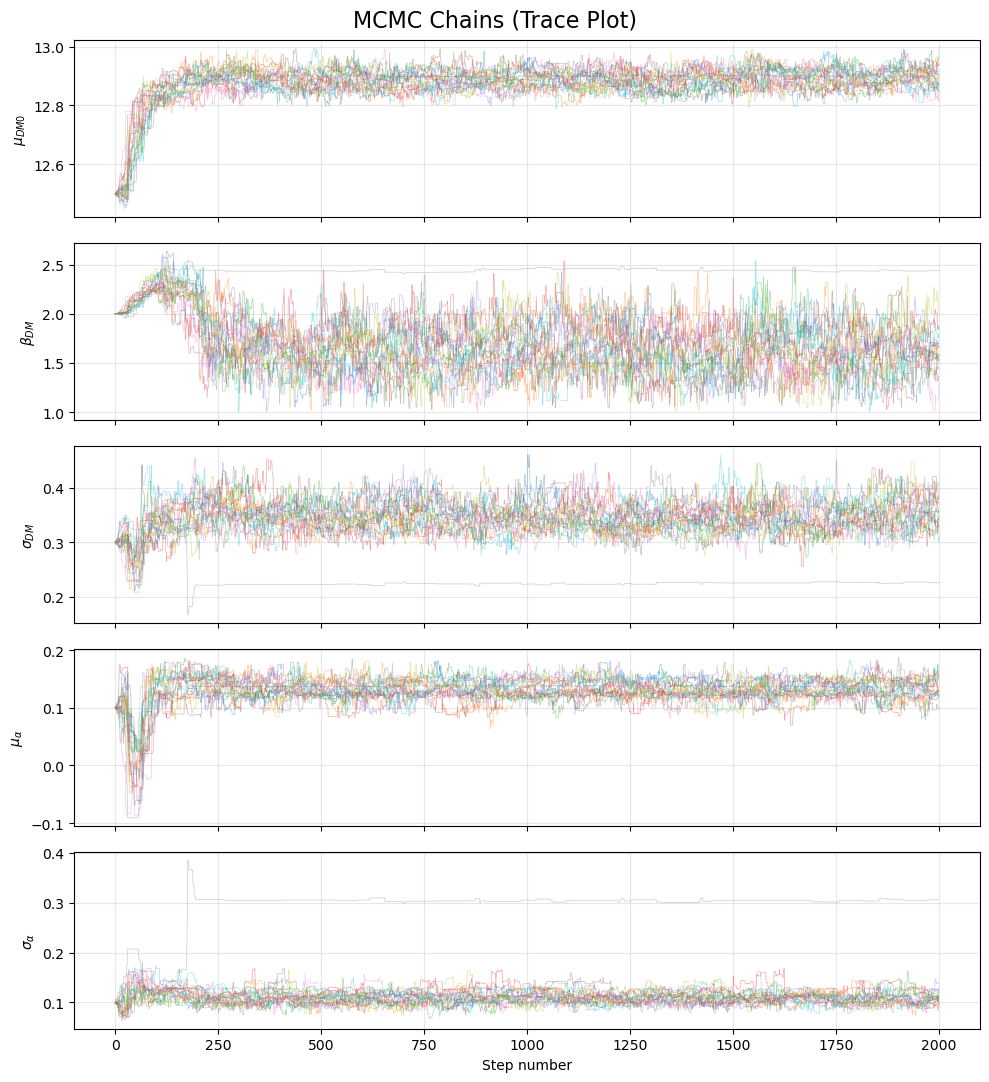

In [49]:
plot_chains(
    hdf5_file="../chains/chains_eta_new_table_no_eta_variedms10006_sigma001.h5",
    discard=0,
    thin=1,
    labels=[r"$\mu_{DM0}$", r"$\beta_{DM}$", r"$\sigma_{DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    max_steps=2000  # 可选
)


In [4]:
from emcee.backends import HDFBackend

backend = HDFBackend("../chains/chains_eta_new_table_no_eta_variedms1.h5", read_only=True)
print("Chain shape:", backend.get_chain().shape)  # → (nsteps, nwalkers, ndim)


Chain shape: (10000, 20, 5)


In [ ]:
(12.455266668203242,
 0.4285884092108674,
 0.08515148383256033,
 0.06776620586484147)

In [3]:
import h5py
with h5py.File("../../chains_eta.h5", "r") as f:
    print(list(f.keys()))               # 应该有 mcmc
    print(list(f["mcmc"].keys()))        # 应该有 chain, log_prob
    print(f["mcmc/chain"].shape)         # (n_steps, n_walkers, ndim)


['mcmc']
['accepted', 'chain', 'log_prob']
(8000, 20, 5)


(4296, 4)


<Figure size 1920x1440 with 0 Axes>

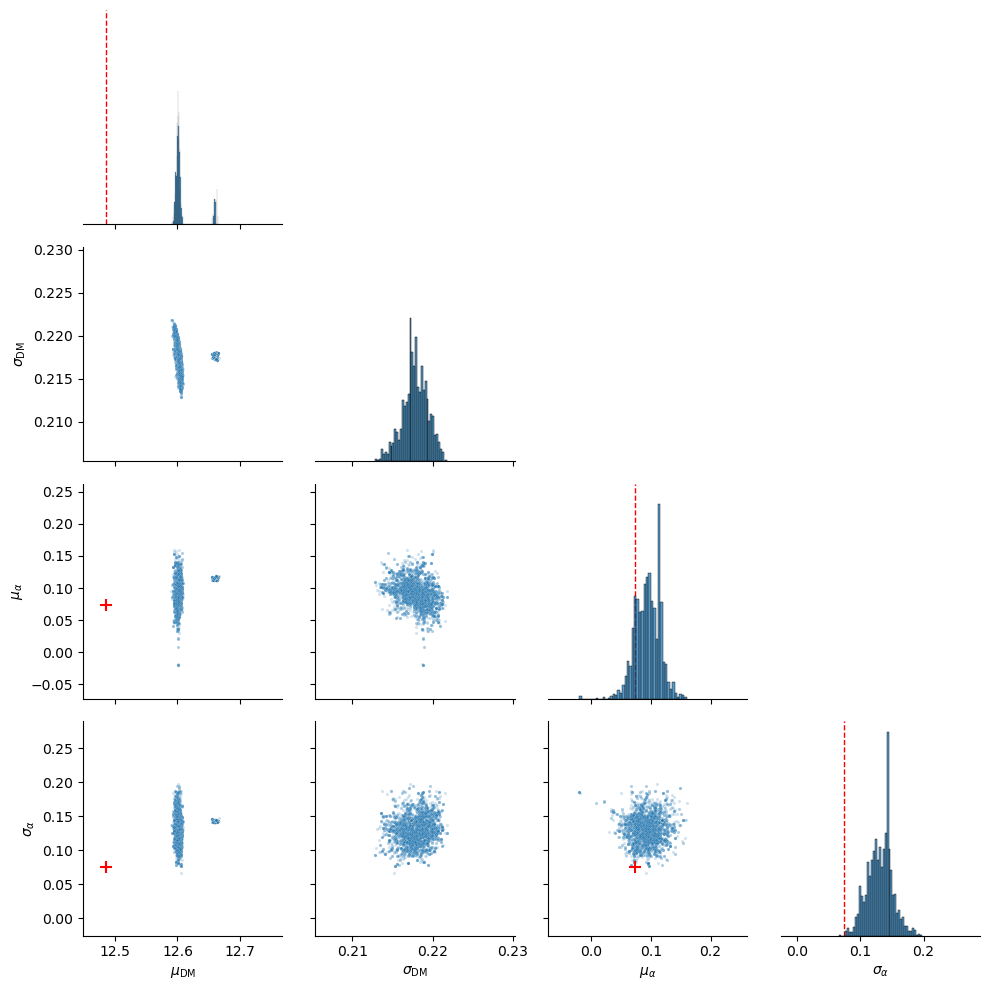

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5):
    """
    使用 Seaborn pairplot 绘制后验图，并以变量均值为中心设置 xlim/ylim，同时标出真值。

    参数：
    - hdf5_file: emcee 的 HDF5 后端路径
    - discard: 前期丢弃步数
    - thin: 抽样间隔
    - labels: 变量标签列表
    - truths: list[float]，真值点，会在每个图上标注
    - width_factor: 控制坐标轴范围宽度因子
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(samples.shape)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()
    plt.figure(dpi=300)
    g = sns.pairplot(df, corner=True, diag_kind="hist", plot_kws=dict(s=5, alpha=0.2))

    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            # 设置 xlim 和 ylim 居中
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    # 添加红色十字真值点
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    # plt.savefig("post.png",dpi=300)
    plt.tight_layout()
    plt.show()
plot_pairplot_with_truth(
    hdf5_file="./mcmc_checkpoint_eta_new_nomutab.h5",
    discard=2200,
    thin=1,
    labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=(12.484790712318109,
 0.4365785108229181,
 0.07376295948617051,
 0.0748739106362481),
    width_factor=8
)


In [22]:
from emcee.backends import HDFBackend
import numpy as np

# 读取链和 log posterior
backend = HDFBackend("mcmc_checkpoint_eta_new_nomutab.h5", read_only=True)
samples = backend.get_chain(discard=2200, thin=1, flat=True)
log_probs = backend.get_log_prob(discard=2200, thin=1, flat=True)

# 找到最大后验的位置（MAP）
max_idx = np.argmax(log_probs)
map_estimate = samples[max_idx]
print("MAP estimate:", map_estimate)


MAP estimate: [12.60081796  0.21823781  0.0956664   0.12465966]


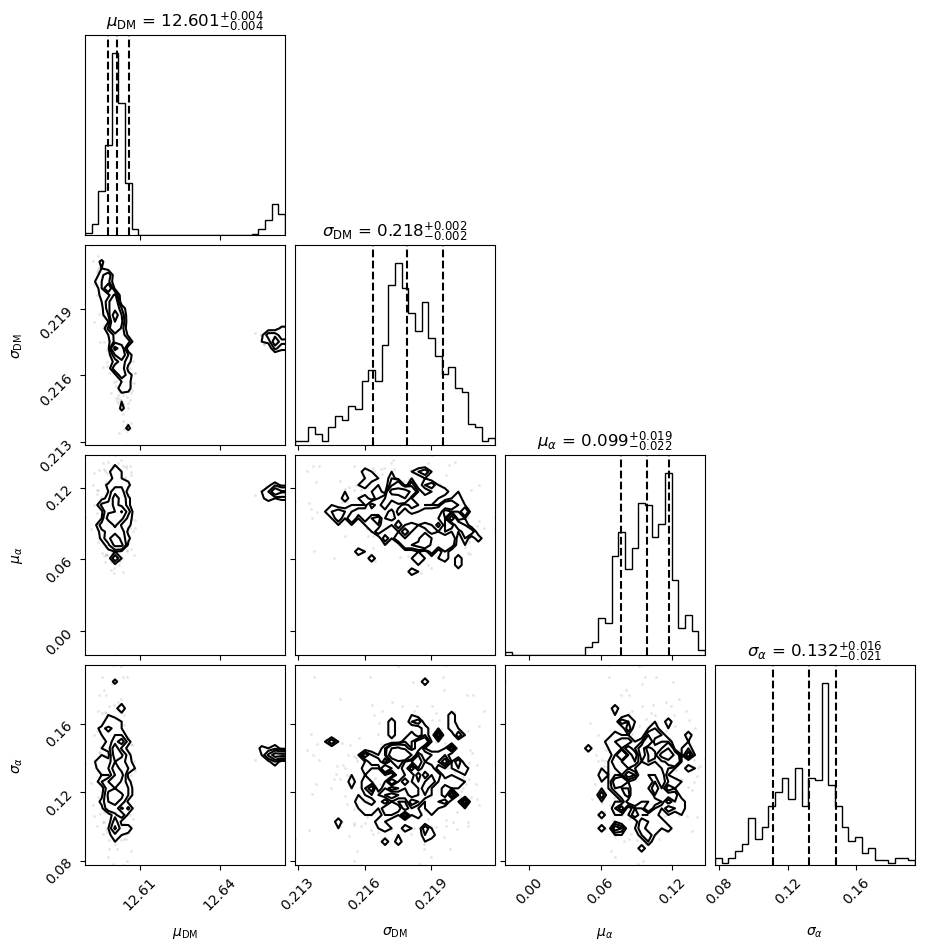

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from emcee.backends import HDFBackend

def plot_posterior_from_hdf5(hdf5_file, discard=1000, thin=10, labels=None, truths=None):
    """
    从 emcee 的 HDF5 后端文件中读取样本并绘制后验角图（corner plot）。

    参数：
    - hdf5_file: str，HDF5 文件路径
    - discard: int，前期 burn-in 步数将被丢弃
    - thin: int，抽样间隔，用于降低样本相关性
    - labels: list[str]，每个维度的标签，用于 corner 图
    - truths: list[float]，真值（如果有），用于在图上标注参考线
    """
    backend = HDFBackend(hdf5_file)

    # 获取扁平化样本链
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]

    fig = corner.corner(
        samples,
        labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
        truths=truths,  # 可选
        show_titles=True,
        title_fmt=".3f",
        title_kwargs={"fontsize": 12},
        quantiles=[0.16, 0.5, 0.84],
        # plot_contours=False,
        plot_density=False,
        fill_contours=False,
        max_n_ticks=3,
        hist_bin_factor=1,
        bins=30,
        smooth=0.0,
        color="black",
        scatter_kwargs=dict(s=3, alpha=0.2)  # 控制散点大小和透明度
    )


# 示例调用（你可替换文件路径和标签）
plot_posterior_from_hdf5(
    "./mcmc_checkpoint_eta_new_nomutab.h5",
    discard=2000,
    thin=10,
    labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=None
)


(1600, 4)


<Figure size 1920x1440 with 0 Axes>

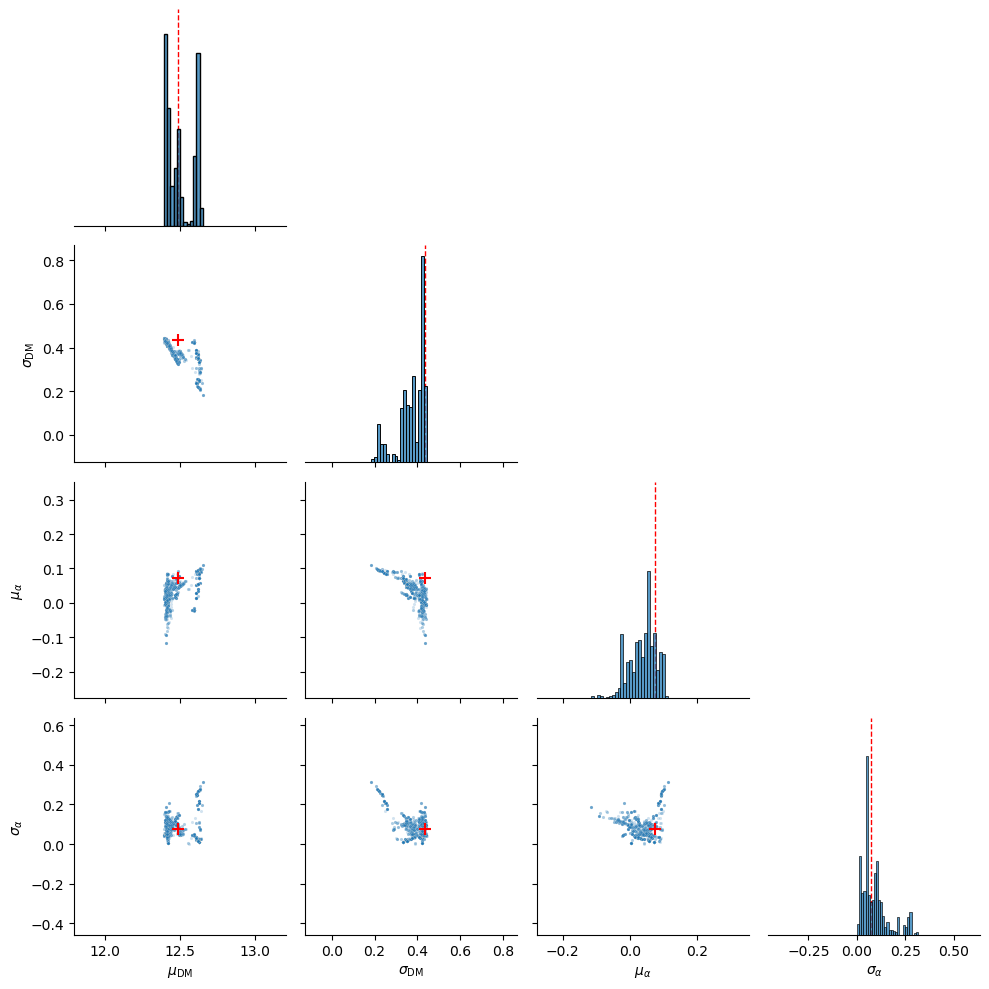

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from emcee.backends import HDFBackend

def plot_pairplot_with_truth(hdf5_file, discard=1000, thin=10, labels=None, truths=None, width_factor=1.5):
    """
    使用 Seaborn pairplot 绘制后验图，并以变量均值为中心设置 xlim/ylim，同时标出真值。

    参数：
    - hdf5_file: emcee 的 HDF5 后端路径
    - discard: 前期丢弃步数
    - thin: 抽样间隔
    - labels: 变量标签列表
    - truths: list[float]，真值点，会在每个图上标注
    - width_factor: 控制坐标轴范围宽度因子
    """
    backend = HDFBackend(hdf5_file, read_only=True)
    samples = backend.get_chain(discard=discard, thin=thin, flat=True)
    print(samples.shape)

    ndim = samples.shape[1]
    if labels is None:
        labels = [f"$\\theta_{i}$" for i in range(ndim)]
    df = pd.DataFrame(samples, columns=labels)

    means = df.mean()
    stds = df.std()
    plt.figure(dpi=300)
    g = sns.pairplot(df, corner=True, diag_kind="hist", plot_kws=dict(s=5, alpha=0.2))

    for i in range(ndim):
        for j in range(i + 1):
            ax = g.axes[i, j]
            if ax is None:
                continue

            # 设置 xlim 和 ylim 居中
            mean_x = means[labels[j]]
            std_x = stds[labels[j]]
            ax.set_xlim(mean_x - width_factor * std_x, mean_x + width_factor * std_x)

            if i == j:
                if truths:
                    ax.axvline(truths[i], color="red", linestyle="--", lw=1)
            else:
                mean_y = means[labels[i]]
                std_y = stds[labels[i]]
                ax.set_ylim(mean_y - width_factor * std_y, mean_y + width_factor * std_y)
                if truths:
                    # 添加红色十字真值点
                    ax.plot(truths[j], truths[i], "r+", markersize=8, markeredgewidth=1.5)
    # plt.savefig("post.png",dpi=300)
    plt.tight_layout()
    plt.show()
plot_pairplot_with_truth(
    hdf5_file="./mcmc_checkpoint_eta_origin2.h5",
    discard=00,
    thin=1,
    labels=[r"$\mu_{\rm DM}$", r"$\sigma_{\rm DM}$", r"$\mu_\alpha$", r"$\sigma_\alpha$"],
    truths=(12.484790712318109,
 0.4365785108229181,
 0.07376295948617051,
 0.0748739106362481),
    width_factor=8
)
